In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from shapely.wkt import loads


In [2]:
dbi = gpd.read_file('./data/Building Permits.geojson')

In [3]:
parcels = pd.read_csv('./data/Blue Sky Code and Inputs/SF_Logistic_Data.csv')

In [4]:
allParcels = gpd.read_file('./data/Parcels   Active and Retired/parcels.shp')

In [5]:
sites = gpd.read_file('./data/site_inventory/xn--Bay_Area_Housing_Opportunity_Sites_Inventory__20072023_-it38a.shp')

In [6]:
tax = pd.read_excel('./data/tax_assessor/2019.8.20__SF_ASR_Secured_Roll_Data_2007-2008.xlsx')

In [7]:
tax8 = pd.read_excel('./data/tax_assessor/2019.8.20__SF_ASR_Secured_Roll_Data_2008-2009.xlsx')

In [8]:
use_codes = pd.read_excel('./data/tax_assessor/2019.8.20__SF_ASR_Secured_Roll_Data_2007-2008.xlsx', 
                          sheet_name='Class & Use Code')

In [9]:
neighborhood_codes = pd.read_excel('./data/tax_assessor/2019.8.20__SF_ASR_Secured_Roll_Data_2007-2008.xlsx', 
                                   sheet_name='Neigborhood Code')

### Training Set is RHNA 4

In [10]:
trainParcels = parcels[np.logical_and(parcels.year >= 2007, parcels.year <= 2015)]

In [11]:
trainY = trainParcels.groupby('MapBlkLot_Master')['Developed'].agg(lambda x: x.ne(0).sum())

In [12]:
trainY.sum()

308

In [13]:
round(trainY.mean(), 3) * 100

0.2

In [14]:
trainX = trainParcels[trainParcels.year == 2007]

No duplicative index.

In [15]:
nunique_lots = trainParcels[trainParcels.year == 2007].MapBlkLot_Master.nunique()
n_lots = trainParcels[trainParcels.year == 2007].shape[0]
assert nunique_lots == n_lots

In [16]:
trainX.MapBlkLot_Master.isin(trainY.index).mean()

1.0

In [17]:
trainDf = pd.merge(trainX.drop('Developed', axis=1), trainY, left_on='MapBlkLot_Master', right_index=True)

In [18]:
trainDf.Developed.value_counts()

0    152910
1       306
2         1
Name: Developed, dtype: int64

In [19]:
def clean_apn(apn):
    apn = ''.join(apn.split(' '))
    if len(apn) < 9:
        return apn
    block_length = 4
    #if apn[block_length].isalpha():
    #    return apn[:block_length] + apn[block_length+1:]
    return apn
 
    
tax['MapBlkLot_Master'] = tax.RP1PRCLID.apply(clean_apn)

### Developed parcels

In [20]:
built = trainDf.loc[trainDf.Developed > 0,]

In [21]:
built.MapBlkLot_Master.isin(tax.MapBlkLot_Master).mean().round(2)

0.45

In [22]:
built.MapBlkLot_Master.str.len().value_counts()

7    286
8     21
Name: MapBlkLot_Master, dtype: int64

In [23]:
built.MapBlkLot_Master

920413      0041103
922617     0129013A
923873      0184042
924274      0196030
925507      0279057
             ...   
1073065     8711025
1073066     8711019
1073070     8711033
1073150     8720117
1073152     8720018
Name: MapBlkLot_Master, Length: 307, dtype: object

In [24]:
dbi.columns

Index(['record_id', 'proposed_construction_type_description', 'issued_date',
       'existing_construction_type_description', 'zipcode',
       'neighborhoods_analysis_boundaries', 'fire_only_permit', 'proposed_use',
       'existing_use', 'description', 'tidf_compliance', 'revised_cost',
       'existing_construction_type', 'site_permit', 'plansets',
       'permit_creation_date', 'status_date',
       'first_construction_document_date', 'existing_units', 'filed_date',
       'street_name', 'block', 'estimated_cost', 'permit_expiration_date',
       'unit_suffix', 'proposed_construction_type', 'permit_type_definition',
       'status', 'completed_date', 'permit_number', 'street_number_suffix',
       'lot', 'number_of_existing_stories', 'street_suffix', 'proposed_units',
       'unit', 'permit_type', 'number_of_proposed_stories',
       'voluntary_soft_story_retrofit', 'supervisor_district', 'street_number',
       'structural_notification', 'geometry'],
      dtype='object')

In [26]:
dbi['units'] = dbi.proposed_units.fillna(0).astype(float) - dbi.existing_units.fillna(0).astype(float)

In [27]:
dbi.status.value_counts()

complete       670325
issued         240489
expired        227734
cancelled       28515
filed           23701
withdrawn        9268
reinstated       1419
filing           1194
approved         1054
disapproved       580
suspend           454
revoked           251
plancheck          55
appeal             29
issuing            24
denied             10
inspection          5
upheld              2
incomplete          2
unknown             2
granted             1
overruled           1
Name: status, dtype: int64

In [28]:
dbi.columns

Index(['record_id', 'proposed_construction_type_description', 'issued_date',
       'existing_construction_type_description', 'zipcode',
       'neighborhoods_analysis_boundaries', 'fire_only_permit', 'proposed_use',
       'existing_use', 'description', 'tidf_compliance', 'revised_cost',
       'existing_construction_type', 'site_permit', 'plansets',
       'permit_creation_date', 'status_date',
       'first_construction_document_date', 'existing_units', 'filed_date',
       'street_name', 'block', 'estimated_cost', 'permit_expiration_date',
       'unit_suffix', 'proposed_construction_type', 'permit_type_definition',
       'status', 'completed_date', 'permit_number', 'street_number_suffix',
       'lot', 'number_of_existing_stories', 'street_suffix', 'proposed_units',
       'unit', 'permit_type', 'number_of_proposed_stories',
       'voluntary_soft_story_retrofit', 'supervisor_district', 'street_number',
       'structural_notification', 'geometry', 'units'],
      dtype='object')

In [29]:
date_cols = [c for c in dbi.columns if 'Date' in c]
dbi[date_cols] = dbi[date_cols].apply(pd.to_datetime)
dbi['apn'] = dbi['block'].astype(str) + dbi['lot'].astype(str)

In [30]:
dbi['na_existing_units'] = dbi['existing_units'].isna()
relevant_uses = [
    'apartments', '1 family dwelling', '2 family dwelling',
    'residential hotel', 'misc group residns.', 'artist live/work',
    'convalescent home', 'accessory cottage', 'nursing home non amb',
    'orphanage', 'r-3(dwg) nursing', 'nursing home gt 6'
]
rhna_permits = dbi[
    dbi['units'] > 0
    & dbi['proposed_use'].isin(relevant_uses)
    & dbi['permit_type'].isin([1, 2, 3, 8])
].copy()

rhna_permits.query('not (`permit_type` == 8 and na_existing_units)', inplace=True)
rhna_permits.query('not (`permit_type` == 3 and na_existing_units)', inplace=True)


# Add / rename columns to fit ABAG format
rhna_permits['permyear'] = rhna_permits['issued_date'].dt.year

# Address is split up into multiple columns. Must re-combine.
id_on_street = rhna_permits['street_number'].astype(str) + " " + rhna_permits['street_number_suffix'].fillna("")
street = rhna_permits['street_name'] + ' ' + rhna_permits['street_suffix']
rhna_permits['address'] = id_on_street + ' ' + street

rhna_permits = rhna_permits.rename(columns={'Location': 'geometry'})

In [31]:
rhna_permits = rhna_permits.loc[np.logical_and(rhna_permits.status_date.dt.year >= 2007,
                                               rhna_permits.status_date.dt.year <= 2015),]

In [32]:
rhna_permits.apn

213        4591D131
214        4591D131
384         5513012
385         5513011
556         1547004
             ...   
1205027     2614087
1205030     3518017
1205032     6551003
1205054     3632040
1205124     3546002
Name: apn, Length: 4761, dtype: object

In [33]:
rhna_permits.apn.isin(parcels.MapBlkLot_Master).mean()

0.6086956521739131

In [34]:
rhna_permits.units

213         18.0
214          8.0
384          2.0
385          1.0
556          1.0
           ...  
1205027      2.0
1205030    135.0
1205032      3.0
1205054      2.0
1205124     15.0
Name: units, Length: 4761, dtype: float64

In [36]:
rhna_permits.apn.isin(built.MapBlkLot_Master).mean()

0.0831758034026465

In [37]:
built.MapBlkLot_Master.isin(rhna_permits.apn).mean()

0.4234527687296417

In [44]:
sum(rhna_permits.apn.duplicated())

2462

In [64]:
completed_projects = rhna_permits[rhna_permits['status'] == 'complete']

In [85]:
dbi_units = completed_projects.groupby(['apn'], sort=False)['units'].median()

In [86]:
built_poisson = built.merge(dbi_units, how='left', left_on='MapBlkLot_Master', right_on='apn')

(array([69.,  4.,  2.,  2.,  5.,  0.,  2.,  1.,  1.,  1.]),
 array([  1. ,  40.8,  80.6, 120.4, 160.2, 200. , 239.8, 279.6, 319.4,
        359.2, 399. ]),
 <BarContainer object of 10 artists>)

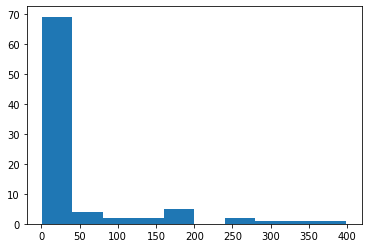

In [89]:
plt.hist(built_poisson.units)

In [95]:
built_poisson.units.isna().mean().round(2)

0.72

I still have 72% of the developed parcels to identify.